# Predict if The Disaster Tweet is Real or Not

- [Kaggle competition dataset](https://www.kaggle.com/competitions/nlp-getting-started/data)

In [7]:
from os import path
import pandas as pd

DATASET_FOLDER = "../data/nlp-getting-started"
TRAIN_FILE = path.join(DATASET_FOLDER, "train.csv") 

## 1. First look at the data

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<Axes: xlabel='target'>

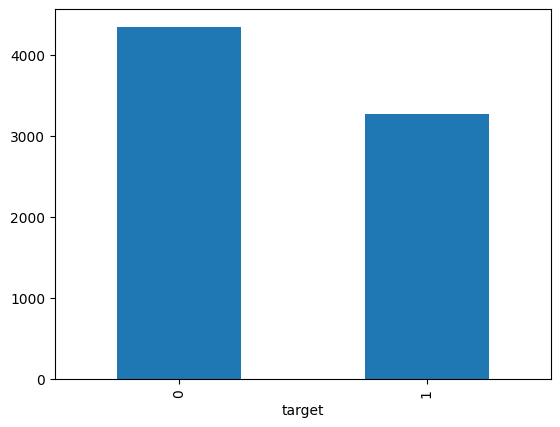

In [8]:
df_tweets = pd.read_csv(TRAIN_FILE)

display(df_tweets.describe())
display(df_tweets.head())
# barplot of the target variable
df_tweets.target.value_counts().plot(kind="bar")

## 2. Metodology

1. Create TF-IDF matrix
2. Plot covariance matrix
3. Select features with highest covariance
4. Apply LDA using selected features

In [9]:
# create TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=1000)
X = vectorizer.fit_transform(df_tweets.text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guilhermeleonardonunes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# get correlation matrix with target variable and select the most correlated features
# create a dataframe with the features and the target variable
df_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
df_features["target"] = df_tweets.target
# get correlation matrix
corr_matrix = df_features.corr()
# get the most correlated features
corr_target = abs(corr_matrix["target"])
relevant_features = corr_target[corr_target > 0.08]
display(relevant_features)
# count relevant features
print("Number of relevant features: {}".format(len(relevant_features)))

atomic          0.091451
bomber          0.094183
bombing         0.098054
california      0.129893
co              0.114944
confirmed       0.083207
debris          0.091213
derailment      0.080811
families        0.083726
fire            0.081304
fires           0.091494
hiroshima       0.119538
homes           0.088923
http            0.136107
japan           0.086389
killed          0.116771
legionnaires    0.081254
malaysia        0.088196
mh370           0.108332
news            0.082022
northern        0.104060
pm              0.082195
severe          0.084950
suicide         0.114074
train           0.084317
typhoon         0.089781
wildfire        0.104769
wreckage        0.080344
target          1.000000
Name: target, dtype: float64

Number of relevant features: 29


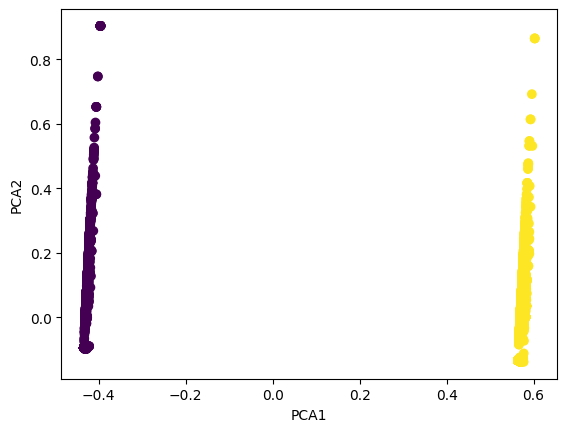

In [22]:
# apply PCA to most correlated features
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_features[relevant_features.index])

# plot PCA
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_features.target)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

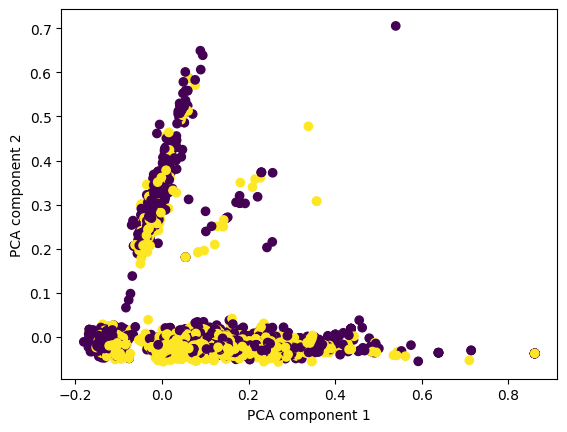

In [12]:
# apply PCA to reduce the dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# plot the PCA components
import matplotlib.pyplot as plt
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_tweets.target)
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.show()

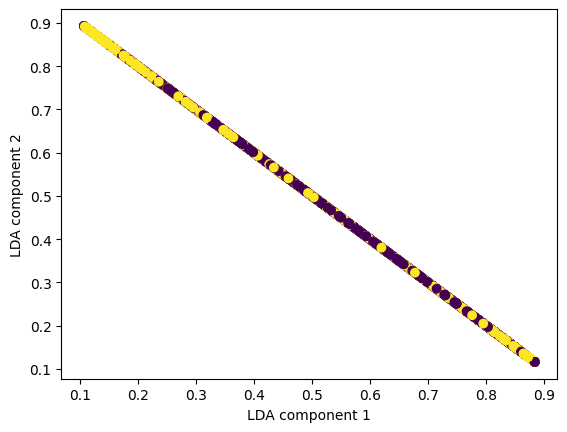

In [13]:
# apply LDA to reduce the dimensionality
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=2)
X_lda = lda.fit_transform(X.toarray())

# plot the LDA components
plt.scatter(X_lda[:,0], X_lda[:,1], c=df_tweets.target)
plt.xlabel("LDA component 1")
plt.ylabel("LDA component 2")
plt.show()
